# Refinement with GSASII, using pySULI Refiner class

The purpose of this notebook is to demonstrate how to do a single refinement with the pySULI library modules.



# General imports

In [11]:
# We need to import some Python libraries here first.
import os    
import sys
import xarray as xr
import numpy as np
import random
import string
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

try:
    %matplotlib widget
except:
    %matplotlib inline

In [12]:
# We need import ipympl packages (if not available pip-install)
try:
    import ipympl
except:
    !! pip install ipympl

Let's check if we are in google colab.

In [13]:
in_colab = True
try:
    from google.colab import drive
except:
    in_colab = False

If in colab, run preperatory methods for using colab. Note that any individual directory strings may be up to change. Otherwise, prepare as we woud on a local machine.

**Crucial note:**
If you are trying to access a directory shared to you, you must create a shortcut to that given directory in your `MyDrive` folder, and then you can access it as we do below (This is how `RTE-24-4876` is accessed below). 

In [14]:
# if running on google colab
if in_colab:
    # setting up a connection to our google drive
    from google.colab import drive
    drive.mount('/content/drive')
    from google.colab import output
    output.enable_custom_widget_manager()

    # setting up the path on the drive to the notebooks, as well as the source code path
    drive_path = '/content/drive/MyDrive/RTE-24-4876/code/pySULI-main/notebooks/'
    os.chdir(drive_path)
    src_path = '/content/drive/MyDrive/RTE-24-4876/code/pySULI-main/src/'
    sys.path += [src_path]

    """
    gsas2_package in here was obtained by the following procedure:
    
    I followed the Linux steps noted here: https://subversion.xray.aps.anl.gov/trac/pyGSAS/wiki/InstallLinux
    - curl https://subversion.xray.aps.anl.gov/admin_pyGSAS/downloads/gsas2full-Latest-Linux-x86_64.sh > /tmp/gsas2full-Latest-Linux-x86_64.sh
    - bash /tmp/gsas2full-Latest-Linux-x86_64.sh -b -p ~/g2full
    
    Instead of ~/g2full I used /content/drive/MyDrive/XRD-on-colab/gsas2_package as install path.
    
    Then I deleted everything except GSASII in /content/drive/MyDrive/XRD-on-colab/gsas2_package folder.
    # There are some redundant stuff (.svn, __pycache__ doc fsource  help PDFfit2 ). I deleted those too.
    """
    
    if not os.path.isdir('gsas2_package'):
    
        print('downlading gsas_package')
        ! gdown 1Mj4zFbWu_qXLTubquLsATeY_bu4qogCO # this is the Google Drive ID for gsas2_package_v5038.zip
        ! unzip gsas2_package_v5038.zip
    
    sys.path += ['gsas2_package/GSASII']
    !pip install pymatgen --use-deprecated=legacy-resolver

if not in_colab:
    sys.path += ['../src']
    # assuming GSAS-II is installed on your machine 
    # as explained here: https://advancedphotonsource.github.io/GSAS-II-tutorials/install.html
    # as a result of "conda create -n GSASII briantoby::gsas2pkg  -c conda-forge", GSAS-II
    # will be installed on a env location. Then we add it to path as below.
    user = "pmeshkov"
    
    match user:
        case "mtopsakal":
            sys.path += ['/home/mt/software/miniforge3/envs/GSASII/GSAS-II/GSASII']
        case "pmeshkov":
            sys.path += ['/opt/anaconda3/envs/GSASII/GSAS-II/GSASII']
        case "kmorell":
            sys.path += ['/Users/kevinmorell/g2full/GSAS-II/GSASII']

In [15]:
import GSASIIscriptable as G2sc
import pybaselines # this comes with gsas2_package
import functions_lib_version as func
import gsas2_functions as rf

from IPython.display import clear_output
#clear_output()

GSAS-II binary directory: /opt/anaconda3/envs/GSASII/GSAS-II/GSASII-bin/mac_64_p3.11_n1.26
7 values read from config file /opt/anaconda3/envs/GSASII/GSAS-II/GSASII/config.py


# Setting up the example data path

In [16]:
# Assuming notebook and data folder are here.

here = os.getcwd()
example_data_path = 'example_data/xrd_refinement_with_gsas2/'

os.chdir('%s/%s'%(here,example_data_path))
os.listdir()

['gsas.instprm',
 'Ceo2.cif',
 'gsas2_scratch',
 'Pt.cif',
 'Zr.cif',
 'Pt.gpx',
 'LaB6.nc',
 'LaB6.cif',
 'ZrH.nc',
 'Zr-H1.66.cif',
 'Background.nc',
 'ZrH.gpx',
 'Pt.nc',
 'LaB6.gpx']

In [17]:
ls

Background.nc  LaB6.gpx       Pt.gpx         Zr.cif         gsas.instprm
Ceo2.cif       LaB6.nc        Pt.nc          ZrH.gpx        gsas2_scratch/
LaB6.cif       Pt.cif         Zr-H1.66.cif   ZrH.nc


# Setting up GSAS-II package and custom refinement functions

In [18]:
# assuming GSAS-II is installed on the machine on conda
# as explained here: https://advancedphotonsource.github.io/GSAS-II-tutorials/install.html
# as a result of "conda create -n GSASII briantoby::gsas2pkg  -c conda-forge", GSAS-II
# will be installed on a eng location. Then we add it to path as below.

import sys

user = "kmorell"

match user:
    case "mtopsakal":
        sys.path += ['/home/mt/software/miniforge3/envs/GSASII/GSAS-II/GSASII']
    case "pmeshkov":
        sys.path += ['/opt/anaconda3/envs/GSASII/GSAS-II/GSASII']
    case "kmorell":
        sys.path += ['/Users/kevinmorell/g2full/GSAS-II/GSASII']

from IPython.display import clear_output

# clear_output()

## GSAS functions in pySULI

All of the GSAS-II functions defined in notebook 005 are contained within the pySULI modules GSAS2_functions and functions_lib_version


# Refinements

In [19]:
#Defining the background
with xr.open_dataset('Background.nc') as ds:
    da_input_bkg = ds.i2d.mean(dim='azimuthal')

In [20]:
#Creating the refiner
first_refiner = rf.Refiner(
    nc_path = 'LaB6.nc',
    phases = [{'cif_abs_path':'LaB6.cif','phase_name':'LaB6','scale':1},],
    gsas2_scratch = None,
    instrument_parameters_file = 'gsas.instprm',
    q_range = None,
    da_input_bkg = None 
#NOTE: Refiner can create its own background if set to None. Try both to see changes in GoF and Rwp
)

/Users/petermeshkov/Repos/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/.gsas2_scratch/1722026422.26_35NNAYZ.tmp/data.xy read by Reader comma/tab/semicolon separated
Instrument parameters read: /Users/petermeshkov/Repos/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/gsas.instprm (G2 fmt) bank None
/Users/petermeshkov/Repos/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/LaB6.cif read by Reader CIF
gpx file saved as /Users/petermeshkov/Repos/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/.gsas2_scratch/1722026422.26_35NNAYZ.tmp/gsas.gpx
gpx file saved as /Users/petermeshkov/Repos/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/.gsas2_scratch/1722026422.26_35NNAYZ.tmp/gsas.gpx


gpx file saved as /Users/petermeshkov/Repos/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/.gsas2_scratch/1722026422.26_35NNAYZ.tmp/gsas.gpx
gpx file saved as /Users/petermeshkov/Repos/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/.gsas2_scratch/1722026422.26_35NNAYZ.tmp/gsas.gpx
gpx file saved as /Users/petermeshkov/Repos/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/.gsas2_scratch/1722026422.26_35NNAYZ.tmp/gsas.gpx
gpx file saved as /Users/petermeshkov/Repos/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/.gsas2_scratch/1722026422.26_35NNAYZ.tmp/gsas.gpx
gpx file saved as /Users/petermeshkov/Repos/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/.gsas2_scratch/1722026422.26_35NNAYZ.tmp/gsas.gpx
gpx file saved as /Users/petermeshkov/Repos/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/.gsas2_scratch/1722026422.26_35NNAYZ.tmp/gsas.gpx
gpx file saved as /Users/petermeshkov/Repos/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/

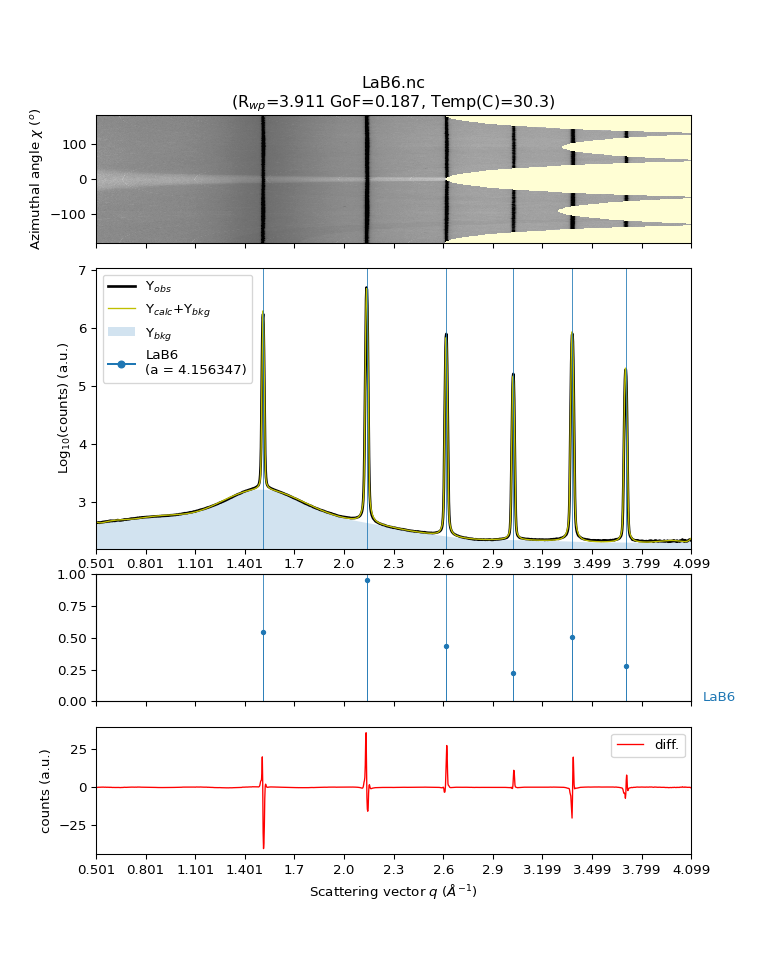

In [21]:
# with pySULI, the 'refinement recipe' has been replaced with functions
first_refiner.refine_background(20)
first_refiner.refine_cell_params()
first_refiner.refine_strain_broadening()
first_refiner.refine_size_broadening()
first_refiner.refine_background(20)
first_refiner.refine_inst_parameters()
first_refiner.save_refinement()
first_refiner.plot_refinement_results()